In [1]:
import time
t1 = time.time()

import pylhe
import ROOT
import math
import os
import pandas as pd
import uproot
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

Welcome to JupyROOT 6.20/04


In [2]:
##### setting file path #####

sig_rootpath = "/data/Chen-Wang/gghh_highPT_250_200K/Events/run_01_decayed_1/tag_1_delphes_events.root"
sig_file = uproot.open(sig_rootpath)

ttbarBG_rootpath = "/data/Chen-Wang/ttbarBG_200K/Events/run_01/tag_1_delphes_events.root"
ttbarBG_file = uproot.open(ttbarBG_rootpath)

jjBG_rootpath = "/data/Chen-Wang/jjBG_200PT_200K/Events/run_01/tag_1_delphes_events.root"
jjBG_file = uproot.open(jjBG_rootpath)

In [3]:
##### include signal data #####

sig_events = [sig_file["Delphes;1"]["FatJet"].array(),
        sig_file["Delphes;1"]["FatJet.Eta"].array(),
        sig_file["Delphes;1"]["FatJet.Phi"].array(),
        sig_file["Delphes;1"]["FatJet.PT"].array(),
        sig_file["Delphes;1"]["FatJet.Mass"].array(),
        sig_file["Delphes;1"]["Jet.BTag"].array(),
        ]

##### reshape the signal data #####

sig_events = np.expand_dims(sig_events, axis=-1)
sig_events = sig_events.transpose((1,0,2))
sig_events = np.squeeze(sig_events,axis=(2,))

num_sig = len(sig_events)

##### include ttbarBG data #####

ttbarBG_events = [ttbarBG_file["Delphes;1"]["FatJet"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Eta"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Phi"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.PT"].array(),
        ttbarBG_file["Delphes;1"]["FatJet.Mass"].array(),
        ttbarBG_file["Delphes;1"]["Jet.BTag"].array(),
        ]

##### reshape the ttbarBG data #####

ttbarBG_events = np.expand_dims(ttbarBG_events, axis=-1)
ttbarBG_events = ttbarBG_events.transpose((1,0,2))
ttbarBG_events = np.squeeze(ttbarBG_events,axis=(2,))

num_ttbarBG = len(ttbarBG_events)

##### include jjBG data #####

jjBG_events = [jjBG_file["Delphes;1"]["FatJet"].array(),
        jjBG_file["Delphes;1"]["FatJet.Eta"].array(),
        jjBG_file["Delphes;1"]["FatJet.Phi"].array(),
        jjBG_file["Delphes;1"]["FatJet.PT"].array(),
        jjBG_file["Delphes;1"]["FatJet.Mass"].array(),
        jjBG_file["Delphes;1"]["Jet.BTag"].array(),
        ]

##### reshape the jjBG data #####

jjBG_events = np.expand_dims(jjBG_events, axis=-1)
jjBG_events = jjBG_events.transpose((1,0,2))
jjBG_events = np.squeeze(jjBG_events,axis=(2,))

num_jjBG = len(jjBG_events)

In [4]:
##### useful function #####

##### select if Fat Jet >= 2 #####

def Fat_Jet_selection(events):
    where1 = np.where(events[:,0]>=2)    ### 0: number of fat jet
    return events[where1]

##### select if M_jet > 50 GeV #####

def mass_selection(events):
    where1 = []
    for i in range(len(events)):
        switch=1
        if events[i][4][0]<50:
            switch=0
        if events[i][4][1]<50:
            switch=0
        if switch==1:
            where1.append(i)
    return events[where1]

##### select if Btag (small jet) >= 2 #####

def Btag_selection(events):
    where1 = []
    for i in range(len(events)):
        if np.sum(events[i][5]) >= 2:    ### 5: Jet.BTag
            where1.append(i)
    return events[where1]

##### calculate X_HH #####

def X_HH(jet_mass1, jet_mass2):
    diff1 = jet_mass1 - 124
    diff2 = jet_mass2 - 124
    if diff1<diff2:
        m1 = jet_mass1
        m2 = jet_mass2
    else:
        m1 = jet_mass2
        m2 = jet_mass1
    return np.sqrt(((m1-124)/(0.1*m1+0.00001))**2 + ((m2-115)/(0.1*m2+0.00001))**2)

##### select X_HH < 10 #####

def X_HH_selection(events):
    where1 = []
    for i in range(len(events)):
        if X_HH(events[i][4][0], events[i][4][1]) < 10:
            where1.append(i)
    return events[where1]

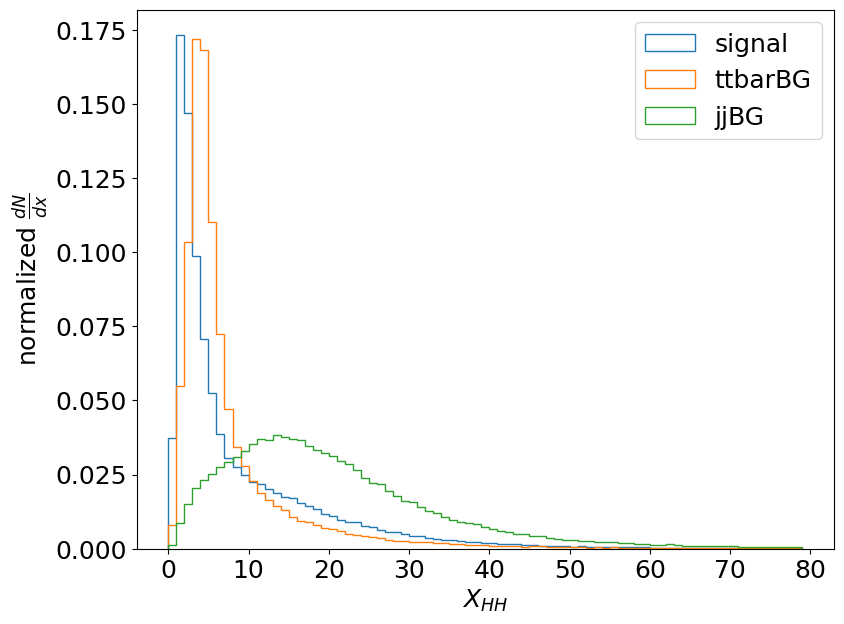

In [5]:
sig_X_HH = []
ttbarBG_X_HH = []
jjBG_X_HH = []

sig_events = Fat_Jet_selection(sig_events)
for i in range(len(sig_events)):
    sig_X_HH.append(X_HH(sig_events[i][4][0], sig_events[i][4][1]))
    
ttbarBG_events = Fat_Jet_selection(ttbarBG_events)
for i in range(len(ttbarBG_events)):
    ttbarBG_X_HH.append(X_HH(ttbarBG_events[i][4][0], ttbarBG_events[i][4][1]))
    
jjBG_events = Fat_Jet_selection(jjBG_events)
for i in range(len(jjBG_events)):
    jjBG_X_HH.append(X_HH(jjBG_events[i][4][0], jjBG_events[i][4][1]))

plt.figure(1, figsize=(9,7))
bins = np.arange(0,80,1)
plt.hist(sig_X_HH, label="signal", histtype='step', density=True, bins=bins)
plt.hist(ttbarBG_X_HH, label="ttbarBG", histtype='step', density=True, bins=bins)
plt.hist(jjBG_X_HH, label="jjBG", histtype='step', density=True, bins=bins)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xlabel(r"$X_{HH}$", fontsize=18)
plt.ylabel(r"normalized $\frac{dN}{dx}$", fontsize=18)
plt.legend(loc='best', fontsize=18)
plt.show()

In [6]:
##### Selection before put into model #####

print("There are totally", num_sig, "signal events.")
sig_events = Fat_Jet_selection(sig_events)
num_sig = len(sig_events)
print("There are", num_sig, "signal events after 2 fat jet selection.")
sig_events = mass_selection(sig_events)
num_sig = len(sig_events)
print("There are", num_sig, "signal events after fat jet mass selection.")
sig_events = Btag_selection(sig_events)
num_sig = len(sig_events)
print("There are", num_sig, "signal events after 2 BTag selection.")
sig_events = X_HH_selection(sig_events)
num_sig = len(sig_events)
print("There are", num_sig, "signal events after X_HH selection.")

print("\nThere are totally", num_ttbarBG, "ttbarBG events.")
ttbarBG_events = Fat_Jet_selection(ttbarBG_events)
num_ttbarBG = len(ttbarBG_events)
print("There are", num_ttbarBG, "ttbarBG events after 2 fat jet selection.")
ttbarBG_events = mass_selection(ttbarBG_events)
num_ttbarBG = len(ttbarBG_events)
print("There are", num_ttbarBG, "ttbarBG events after fat jet mass selection.")
ttbarBG_events = Btag_selection(ttbarBG_events)
num_ttbarBG = len(ttbarBG_events)
print("There are", num_ttbarBG, "ttbarBG events after 2 BTag selection.")
ttbarBG_events = X_HH_selection(ttbarBG_events)
num_ttbarBG = len(ttbarBG_events)
print("There are", num_ttbarBG, "ttbarBG events after X_HH selection.")

print("\nThere are totally", num_jjBG, "jjBG events.")
jjBG_events = Fat_Jet_selection(jjBG_events)
num_jjBG = len(jjBG_events)
print("There are", num_jjBG, "jjBG events after 2 fat jet selection.")
jjBG_events = mass_selection(jjBG_events)
num_jjBG = len(jjBG_events)
print("There are", num_jjBG, "jjBG events after fat jet mass selection.")
jjBG_events = Btag_selection(jjBG_events)
num_jjBG = len(jjBG_events)
print("There are", num_jjBG, "jjBG events after 2 BTag selection.")
jjBG_events = X_HH_selection(jjBG_events)
num_jjBG = len(jjBG_events)
print("There are", num_jjBG, "jjBG events after X_HH selection.")

There are totally 200000 signal events.
There are 174453 signal events after 2 fat jet selection.
There are 140271 signal events after fat jet mass selection.
There are 117438 signal events after 2 BTag selection.
There are 102879 signal events after X_HH selection.

There are totally 200000 ttbarBG events.
There are 123751 ttbarBG events after 2 fat jet selection.
There are 109522 ttbarBG events after fat jet mass selection.
There are 55248 ttbarBG events after 2 BTag selection.
There are 50065 ttbarBG events after X_HH selection.

There are totally 200000 jjBG events.
There are 123337 jjBG events after 2 fat jet selection.
There are 54308 jjBG events after fat jet mass selection.
There are 1702 jjBG events after 2 BTag selection.
There are 1033 jjBG events after X_HH selection.
